In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import proplot as pplt

import pygeohydro as gh
import pygeoutils as geoutils
from pygeohydro import NID, NWIS
from pynhd import NLDI, WaterData, ZeroMatched

C:\Users\keonm\miniconda3\envs\pygeo-hyriver2\lib\site-packages\proplot\__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


https://docs.hyriver.io/examples/notebooks/dam_impact.html  

In [2]:
pplt.rc["figure.facecolor"] = "w"

In [3]:
start = "1985-01-01"
end = "2015-01-01"
texas = gh.helpers.get_us_states("contiguous")
texas = texas[texas.STUSPS == "TX"]

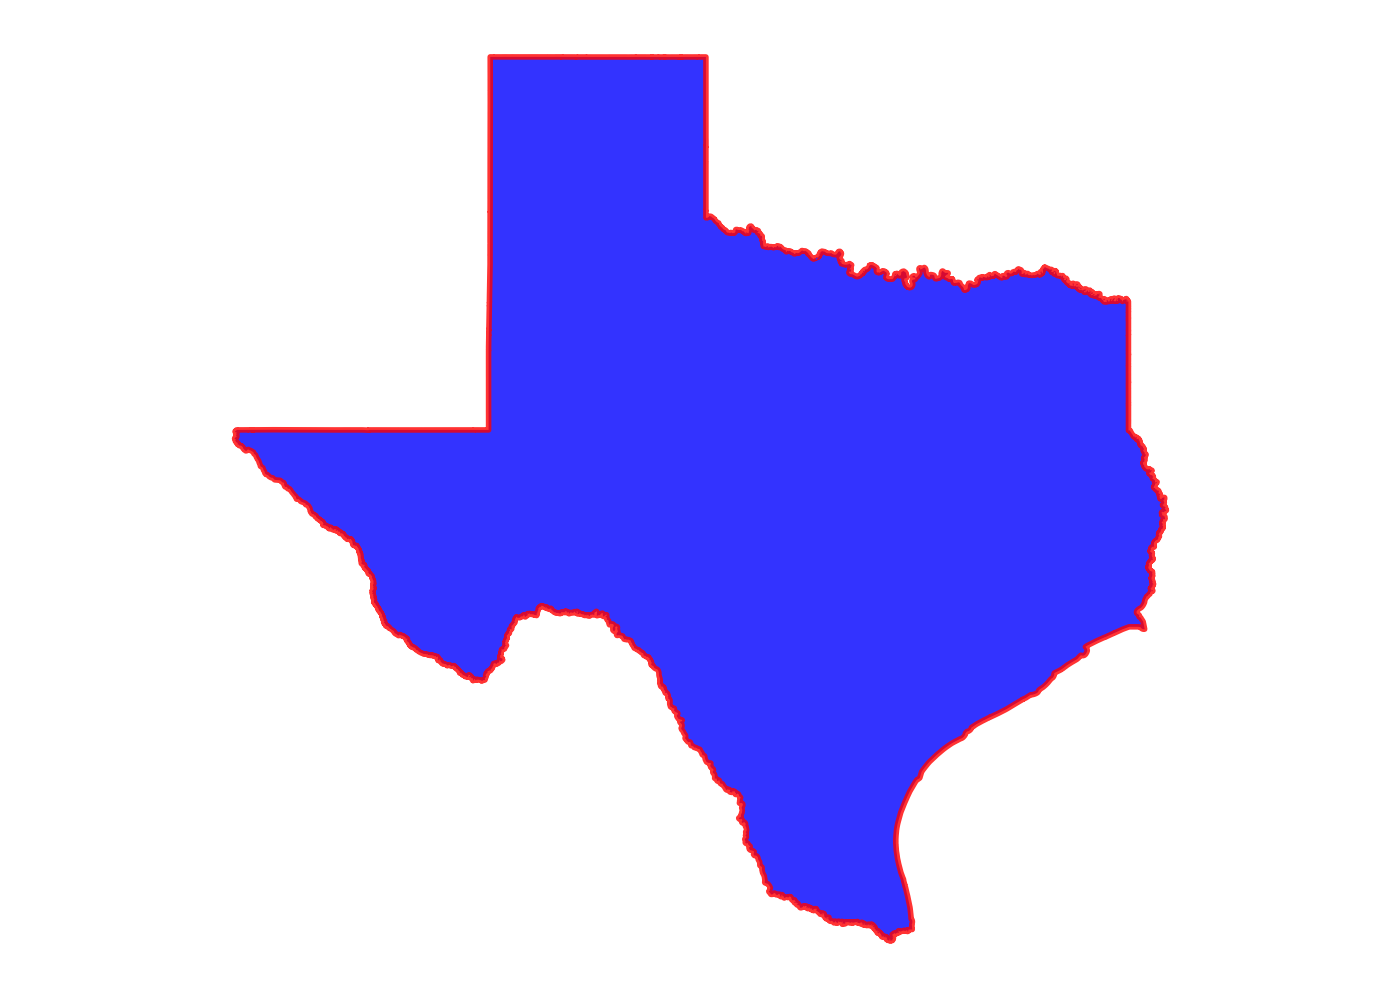

In [4]:
_, ax = pplt.subplots(refwidth=7)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
ax.set_axis_off()

In [5]:
nwis = NWIS()
query = {
    "stateCd": "TX",
    "startDt": start,
    "endDt": end,
    "outputDataTypeCd": "dv",  # daily values
    "hasDataTypeCd": "dv",  # daily values
    "parameterCd": "00060",  # discharge
}
sites = nwis.get_info(query)
sites.shape[0]

3857

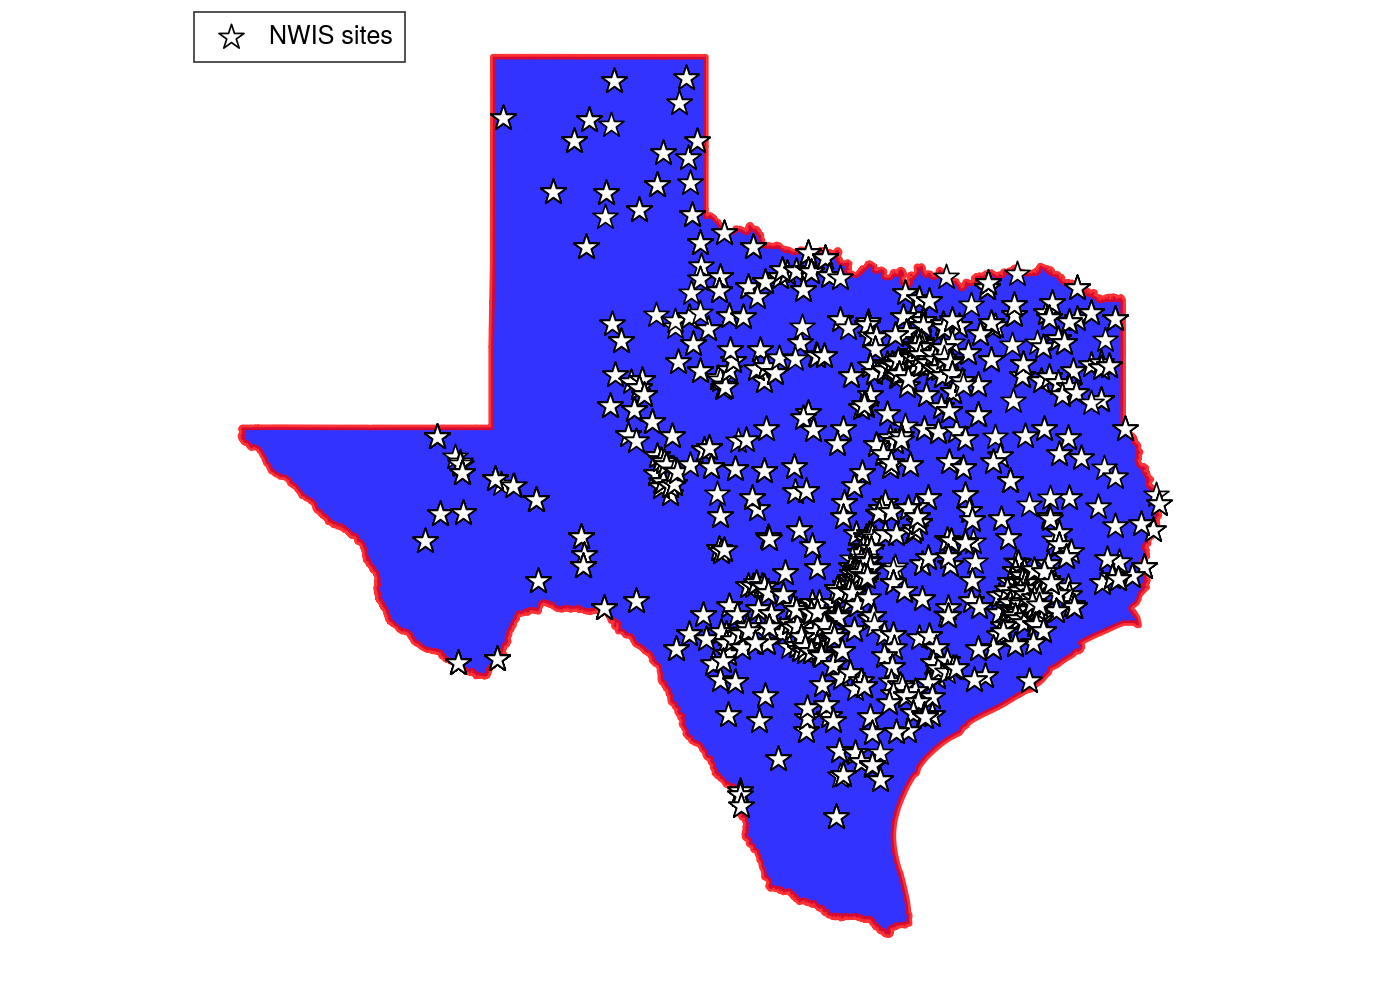

In [6]:
_, ax = pplt.subplots(refwidth=7)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

In [7]:
sites = sites[
    (sites.parm_cd == "00060")  # discharge
    & (sites.stat_cd == "00003")  # mean
    & (sites.count_nu >= 30 * 365)  # at least 30 years of data
    & ~sites.hcdn_2009  # not pristine
    & (sites.drain_sqkm > 10)
].copy()
sites.shape[0]


281

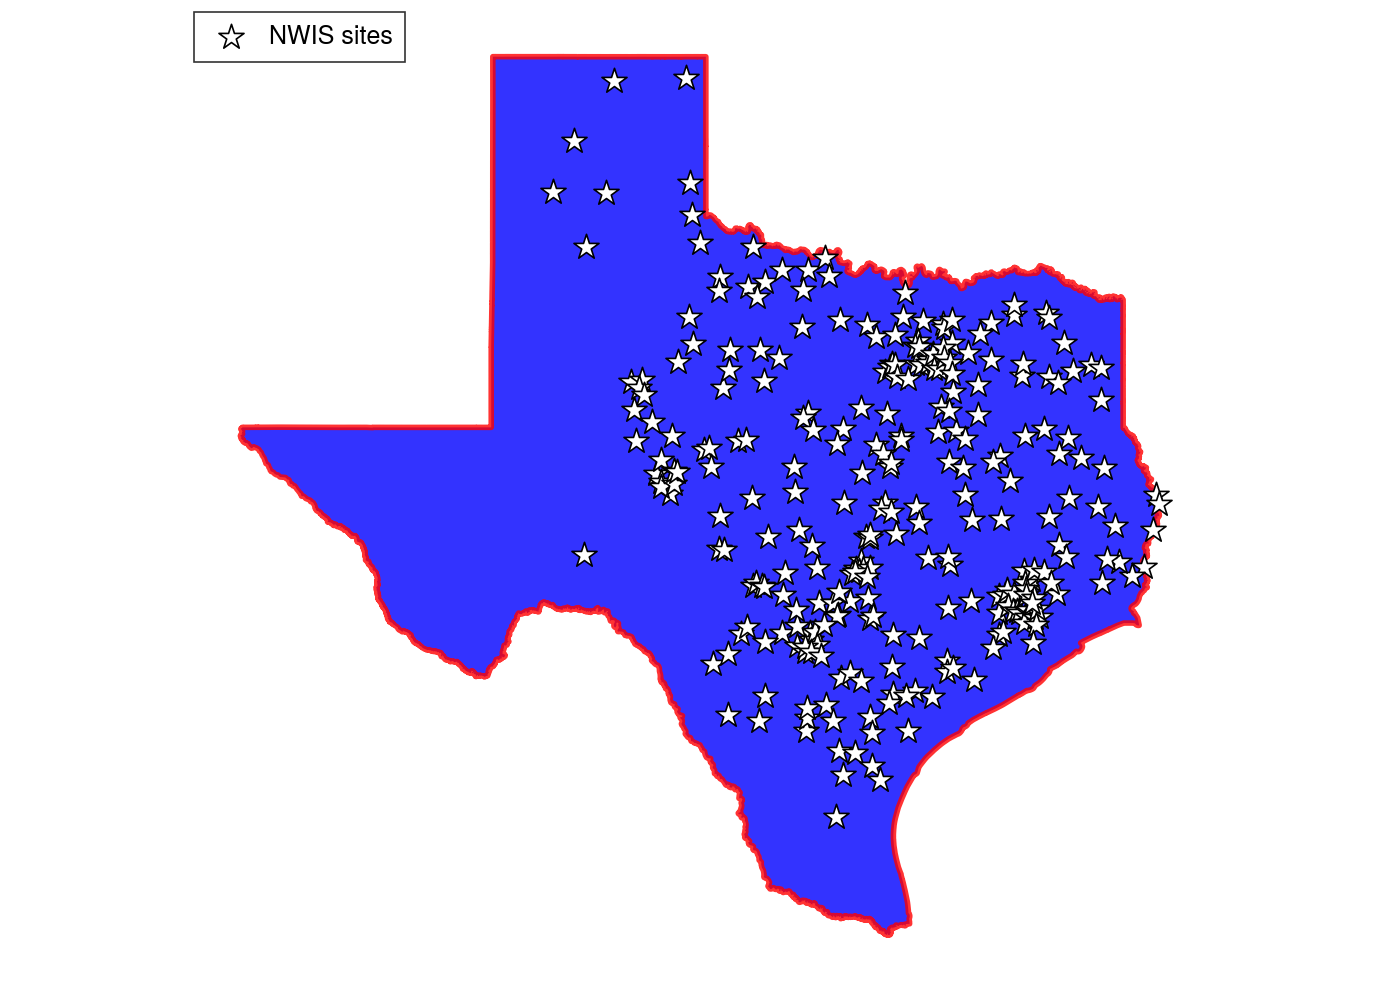

In [8]:
_, ax = pplt.subplots(refwidth=7)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

# Dams

In [9]:
nid = NID()
nid.valid_fields[nid.valid_fields.str.contains("year", case=False)]

70      yearCompleted
71    yearCompletedId
83      yearsModified
Name: name, dtype: object

In [10]:
nid.valid_fields[nid.valid_fields.str.contains("state", case=False)]

13                stateFedId
17          stateRegulatedId
19     stateRegulatoryAgency
31                     state
32                 cityState
39               countyState
177                 stateKey
Name: name, dtype: object

In [11]:
dam_list = nid.get_byfilter(
    [
        {
            "stateKey": ["TX"],
            "yearCompleted": ["[1995 2005]"],
        },
    ],
)
dams = dam_list[0]

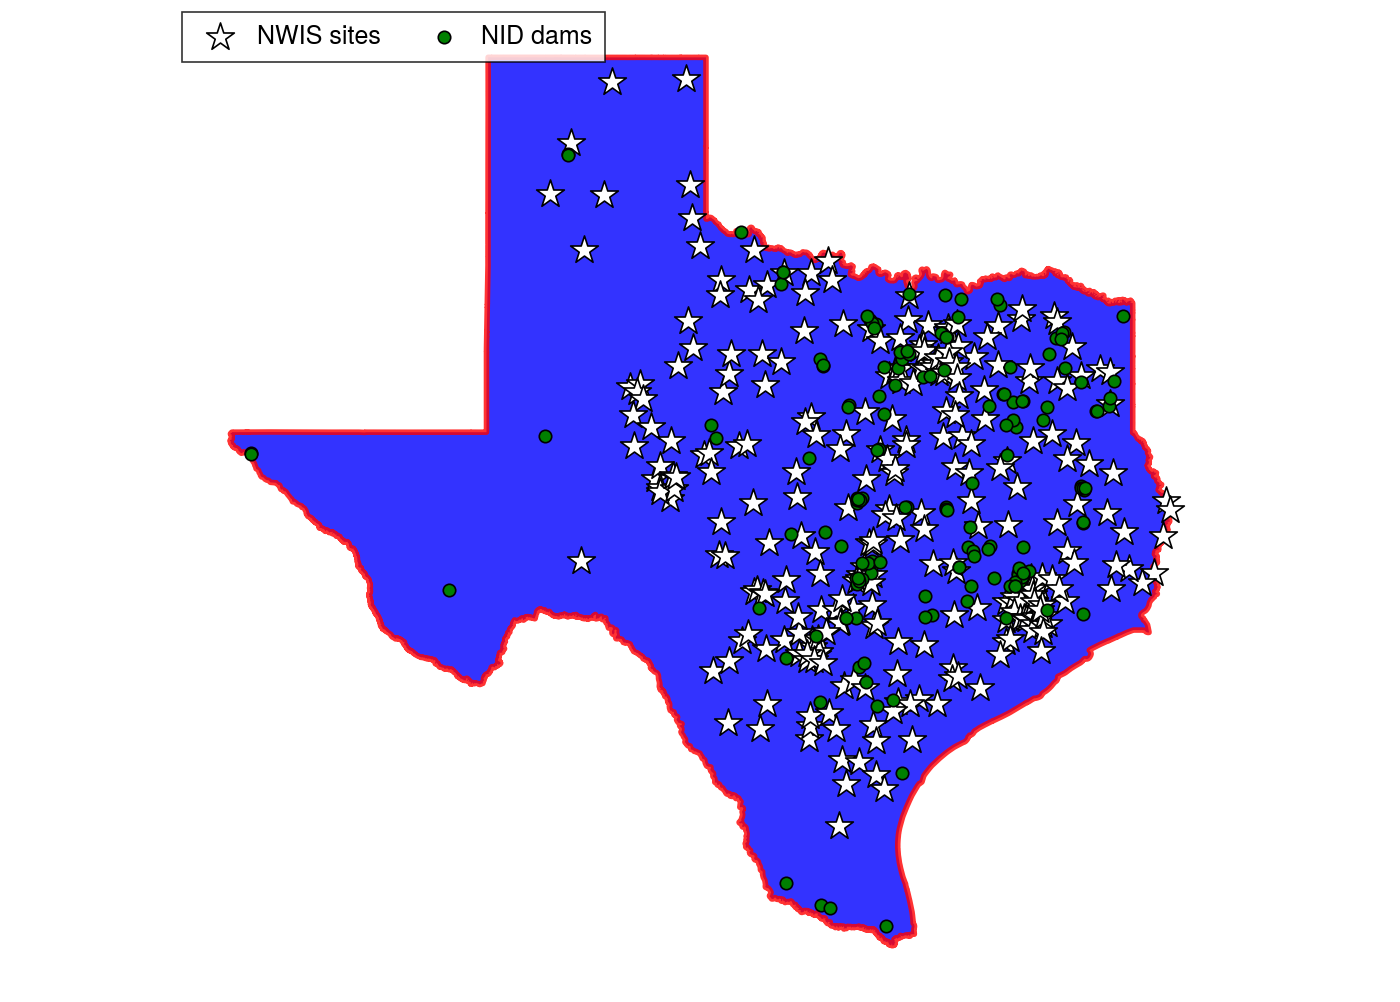

In [12]:
_, ax = pplt.subplots(refwidth=7)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

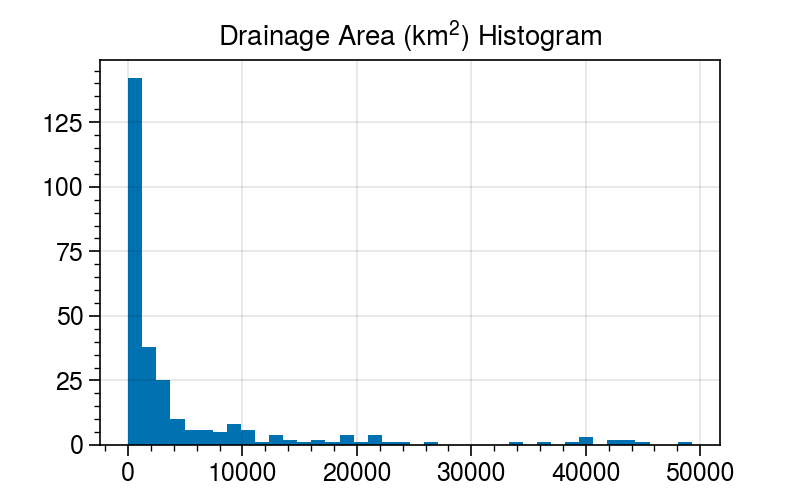

In [13]:
ax = sites.hist("drain_sqkm", figsize=(4, 2.5), bins="auto")
_ = ax[0][0].set_title("Drainage Area (km$^2$) Histogram")

In [14]:
def distance_filter(gdf1, gdf2, dist_km):
    """Filter gdf1 to only include points within distance of gdf2."""
    buff = gdf1.to_crs(5070).buffer(dist_km * 1e3)
    idx2, idx1 = buff.sindex.query_bulk(gdf2.to_crs(5070).geometry)
    return gdf1.iloc[pd.unique(idx1)].reset_index(drop=True), gdf2.iloc[
        pd.unique(idx2)
    ].reset_index(drop=True)

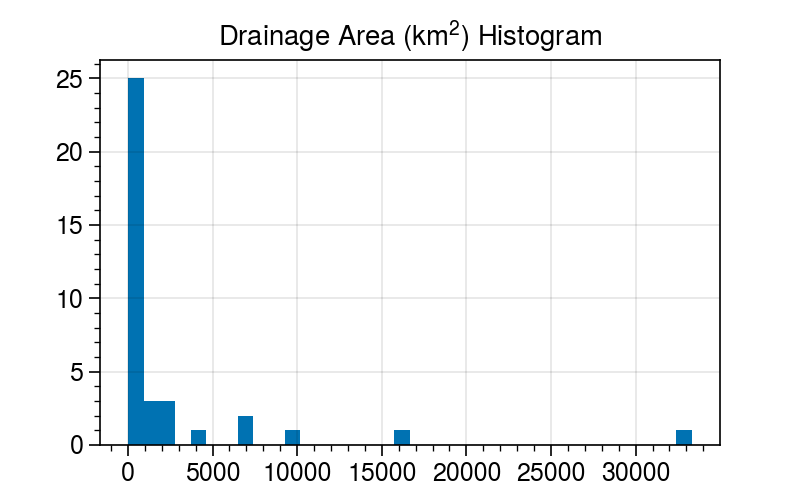

In [15]:
sites, dams = distance_filter(sites, dams, 10)

ax = sites.hist("drain_sqkm", figsize=(4, 2.5), bins="auto")
_ = ax[0][0].set_title("Drainage Area (km$^2$) Histogram")

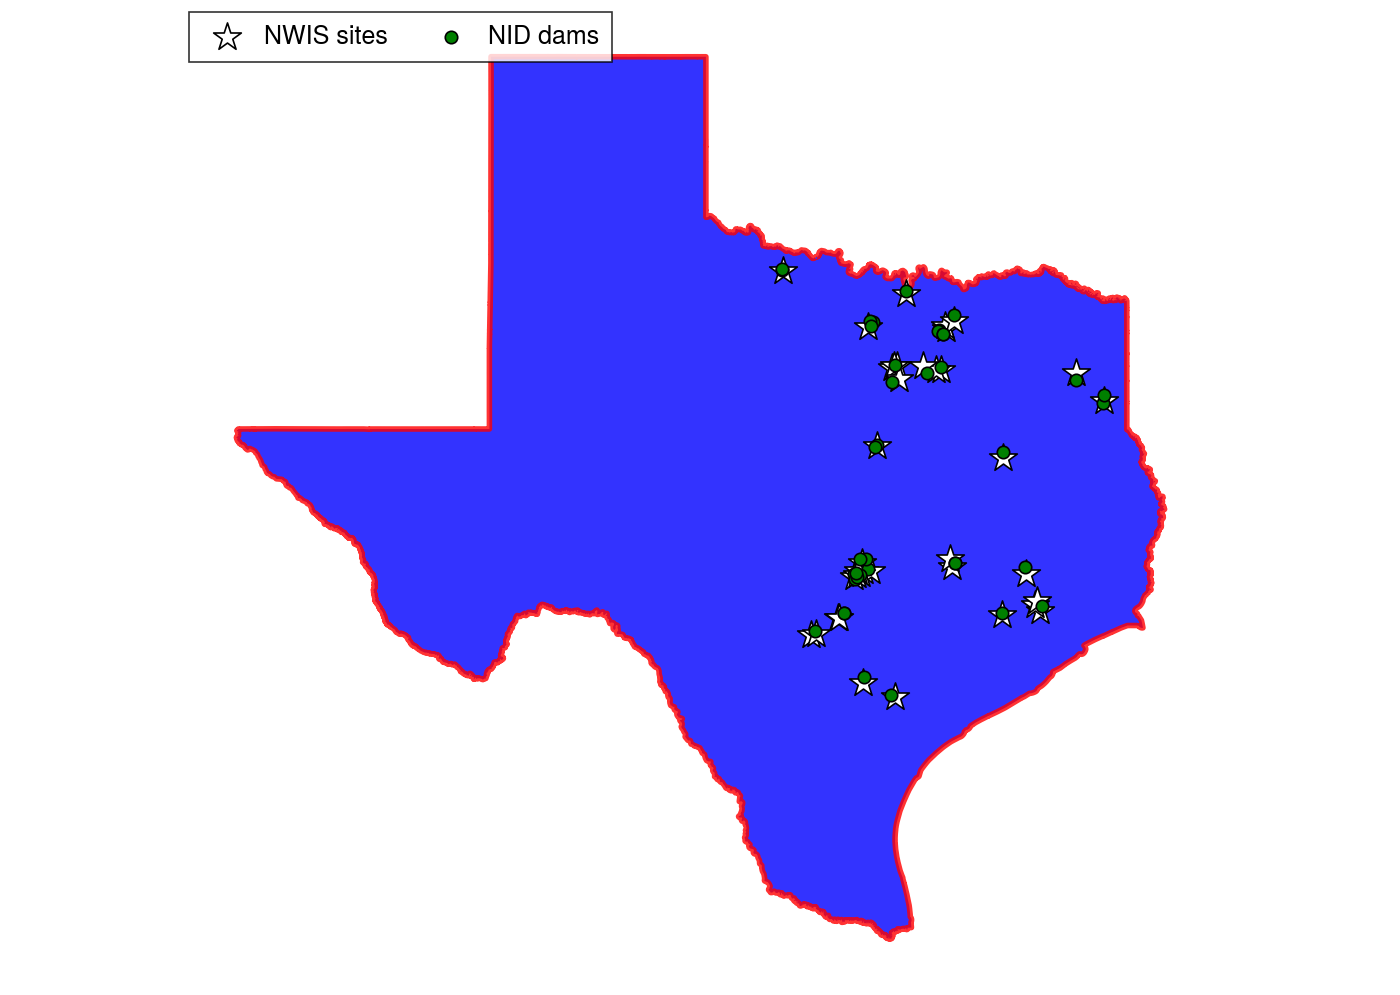

In [16]:
_, ax = pplt.subplots(refwidth=7)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

# Flowlines and Hydrolinking

In [17]:
nldi = NLDI()

In [18]:
flw_up = {}
noflw = []
for agency, fid in sites[["agency_cd", "site_no"]].itertuples(index=False, name=None):
    try:
        flw_up[fid] = nldi.navigate_byid(
            fsource="nwissite",
            fid=f"{agency}-{fid}",
            navigation="upstreamTributaries",
            source="flowlines",
            distance=10)
    except ZeroMatched:
        noflw.append(fid)
noflw

['08058900', '08059400']

In [19]:
import pynhd

print(pynhd.__version__)

0.13.3


In [23]:
from pynhd import NLDI, WaterData
import pynhd as nhd

nldi = NLDI()
comids = nldi.navigate_byid(
    fsource="nwissite",
    fid="USGS-01031500",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000,
).nhdplus_comid.to_list()

In [ ]:
sites = sites[sites.site_no.isin(flw_up)].copy()
sites, dams = distance_filter(sites, dams, 10)

In [ ]:
coords = list(dams[["longitude", "latitude"]].astype(float).itertuples(index=False, name=None))
nid_comids = nldi.comid_byloc(coords)
missing = []
if isinstance(nid_comids, tuple):
    nid_comids, missing = nid_comids

if missing:
    dams = dams.drop(index=[coords.index(i) for i in missing])
    sites, dams = distance_filter(sites, dams, 10)

dams["nhdplus_comid"] = nid_comids.comid

In [ ]:
coords = list(sites[["dec_long_va", "dec_lat_va"]].astype(float).itertuples(index=False, name=None))
site_comids = nldi.comid_byloc(coords)
missing = []
if isinstance(site_comids, tuple):
    site_comids, missing = site_comids

if missing:
    sites = sites.drop(index=[coords.index(i) for i in missing])
    sites, dams = distance_filter(sites, dams, 10)

sites["nhdplus_comid"] = site_comids.comid

In [ ]:
flw_all = pd.concat(flw_up.values(), keys=flw_up.keys()).reset_index().drop(columns="level_1")
flw_all = gpd.GeoDataFrame(
    flw_all.rename(columns={"level_0": "usgs_id"}), crs=flw_up["07312200"].crs
)
flw_all.head()

In [ ]:
flw_dam = pd.merge(
    flw_all[["usgs_id", "nhdplus_comid"]],
    dams[["id", "nhdplus_comid"]].rename(columns={"id": "dam_id"}),
    on="nhdplus_comid",
    how="left",
)
flw_dam = flw_dam[~flw_dam.dam_id.isna()].reset_index(drop=True)
flw_dam["dam_id"] = flw_dam.dam_id.astype(int)
flw_dam

In [ ]:
site_dam = flw_dam.usgs_id.unique()
site_dam

# Streamflow Observations

In [20]:
dams_info = nid.inventory_byid(flw_dam.dam_id.to_list())
dams_info.head()

NameError: name 'flw_dam' is not defined